# IQ Noise Detection Inference
This Notebook assumes post pass JSON reports of IQ Constellation plots
1. Apply KMeans Clustering to map blobs to clusters
2. Extract Blob Shape by applying Covariance Error Ellipse
3. Plot new metrics next to raw blob plot
4. Use AutoGluon Classifier to infer Interference/Phase Noise/Amplifier Gain Noise
5. Write report to S3

conda_python3, ml.m5.xlarge

In [ ]:
!pip install autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
import sagemaker
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import time
import datetime
import os
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from matplotlib.path import Path
from time import gmtime, strftime
import io

from utility import confidence_ellipse, line_distance

In [5]:
# Constants
STD_DEV = 2.5
CLUSTERS = 32 # todo read out of report.json

## Extract Blob Shape Metrics, Covariance Error Ellipse

In [6]:
def process(timestamps, data_type, flag=False):
    result_buffer = []
    for i in range(len(timestamps)):

        X = timestamps[i]
        real = np.real(X)
        imag = np.imag(X)
        X = np.concatenate([real.reshape(-1, 1), imag.reshape(-1, 1)], axis=1)
        
        # Map Blobs into clusters
        y_pred = KMeans(n_clusters=CLUSTERS).fit_predict(X)

        # Plot with clusters
        axs[i][0].scatter(X[:, 0], X[:, 1], c=y_pred)
        
        # Build object of {cluster, [x,y]}
        Y = []
        for j in range(CLUSTERS):
            Y.append([])
        for j in range(len(X)):
            Y[y_pred[j]].append(X[j])
        if (flag):
            Y = np.array(np.array([np.array(Y) for Y in Y], dtype=object), dtype=np.float32)
        else:
            Y = np.array(np.array([np.array(Y) for Y in Y], dtype=object), dtype=object)

        density = []
        ratio = []
        major_axis = []
        minor_axis = []
        major_rotation = 0

        for j in range(len(Y)):
            # Generate Ellipse
            ellipse = confidence_ellipse(Y[j][:,0], Y[j][:,1], n_std=STD_DEV)
            maj_axis = [ellipse['center'][0], ellipse['center'][0]+ellipse['major_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['major_axis'][1]]
            min_axis = [ellipse['center'][0], ellipse['center'][0]+ellipse['minor_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['minor_axis'][1]]
            res = line_distance(maj_axis, min_axis, (0,0))
            if (not res):
                major_rotation += 1
            major_axis.append(maj_axis)
            minor_axis.append(min_axis)
            density.append(ellipse['density'])
            ratio.append(ellipse['ratio'])

            # Add to plot
            axs[i][1].add_patch(ellipse['ellipse'])
            axs[i][1].plot([ellipse['center'][0], ellipse['center'][0]+ellipse['major_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['major_axis'][1]], color='r', linewidth=2)
            axs[i][1].plot([ellipse['center'][0], ellipse['center'][0]+ellipse['minor_axis'][0]], [ellipse['center'][1], ellipse['center'][1]+ellipse['minor_axis'][1]], color='g', linewidth=2)        
            axs[i][1].plot(Y[j][:,0], Y[j][:,1], 'o')
            
        # Analyze features
        major_axis_np = np.array(major_axis)
        minor_axis_np = np.array(minor_axis)
        density_np = np.array(density)
        ratio_np = np.array(ratio)
        result_buffer.append( {
            'density_avg': np.mean(density_np, axis=0), 
            'density_std': np.std(density_np, axis=0), 
            'ratio_avg': np.mean(ratio_np, axis=0), 
            'ratio_std': np.std(ratio_np, axis=0),
            'major_axis_avg': np.mean(major_axis_np, axis=0), 
            'major_axis_std': np.std(major_axis_np, axis=0),
            'minor_axis_avg': np.mean(minor_axis_np, axis=0), 
            'minor_axis_std': np.std(minor_axis_np, axis=0),            
            'rotation': (major_rotation /CLUSTERS), 
            'blobs': CLUSTERS})
    return result_buffer

## Process sample data

[{'class': 'phase_noise', 'timestamp': 1706627715.9736133, 'fileId': '5687465385.35.txt'}, {'class': 'phase_noise', 'timestamp': 1706627715.973633, 'fileId': '6687373903.57.txt'}]


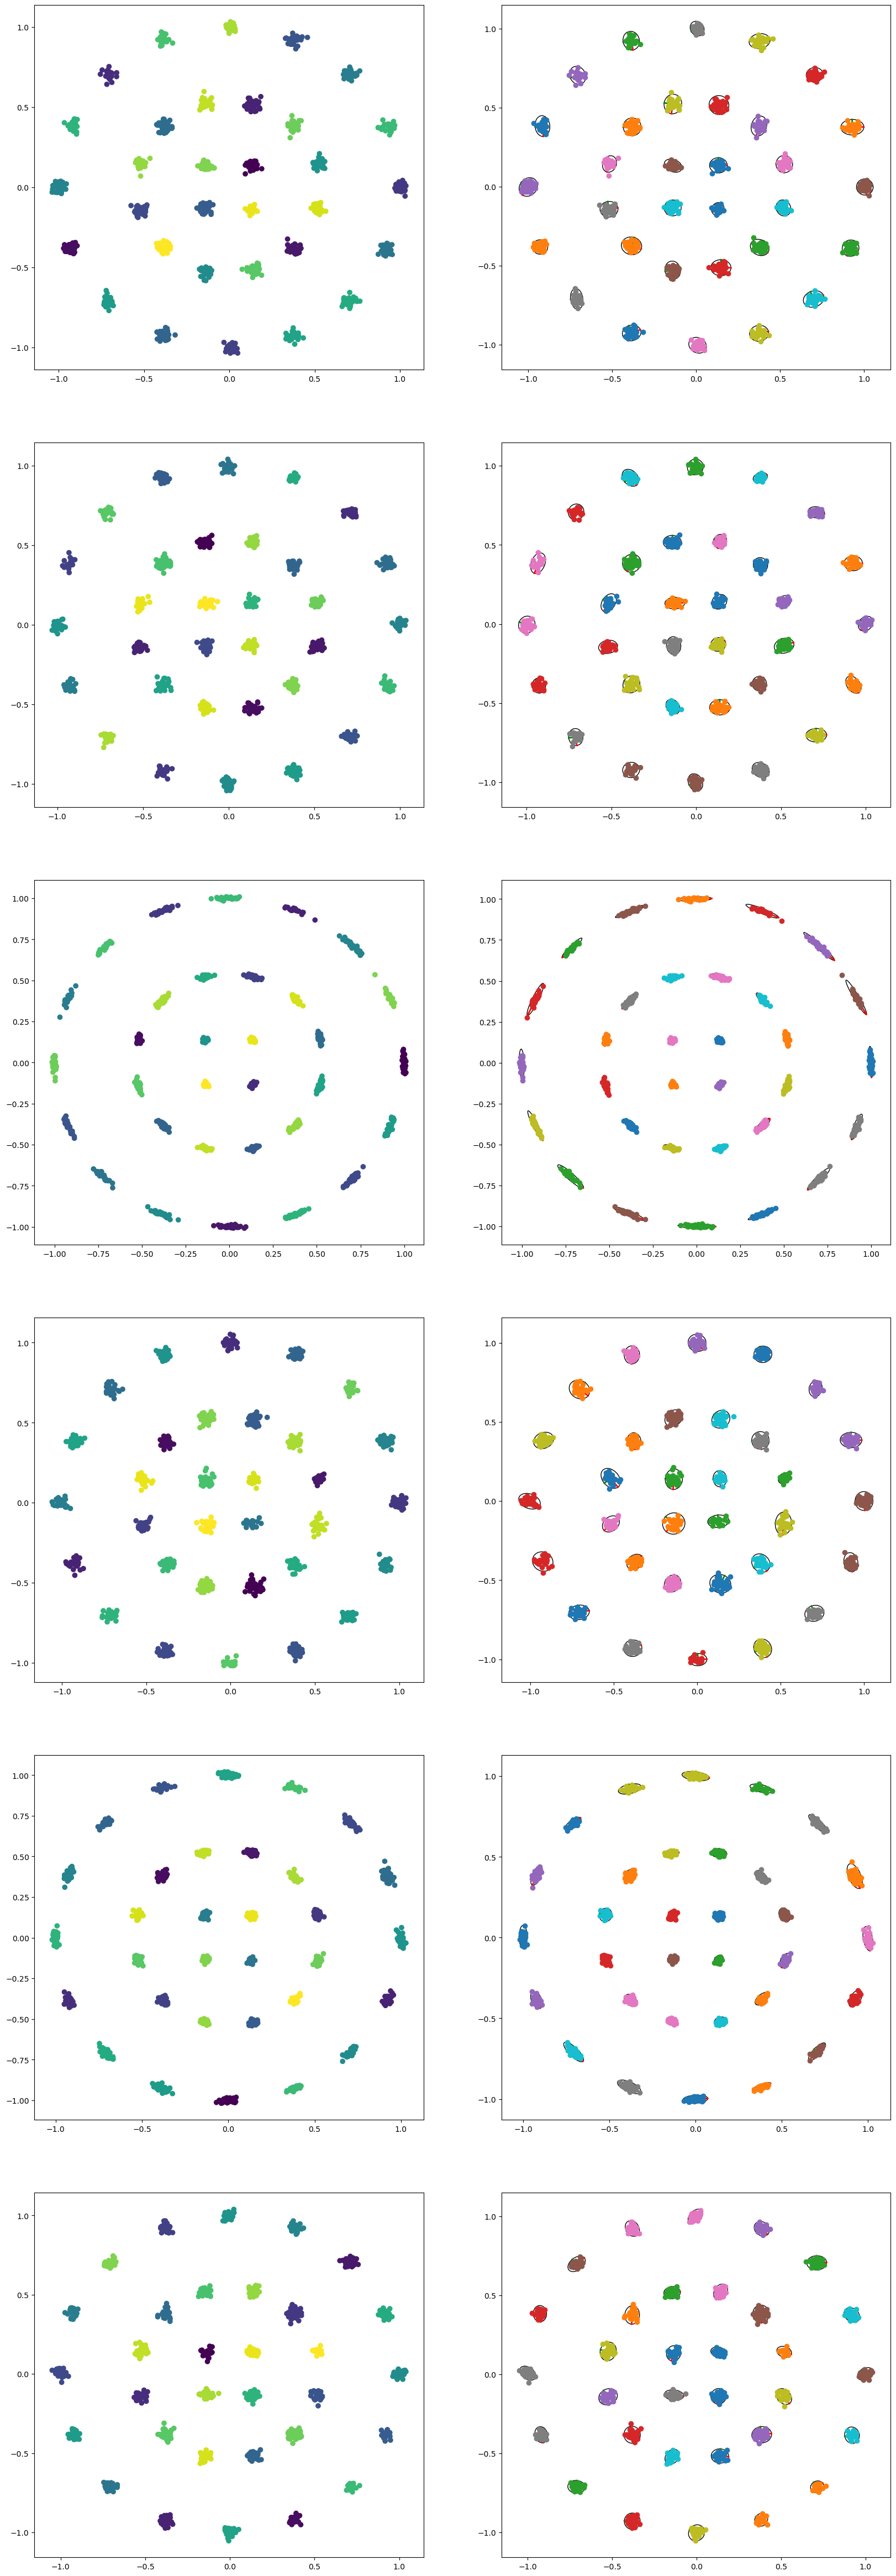

In [9]:
data_type = ''
timestamps = []

# -------------- Parse -------------- #

fn = os.listdir('./inference')
for f in fn:
    if (data_type == 'compression'):
        timestamps.append(np.load('./data/%s/%s' % ( file_path,f), allow_pickle=True))
    else:
        timestamps.append(np.fromfile(open('./inference/%s' % f), dtype=np.complex64))
fig, axs = plt.subplots(nrows=len(timestamps), ncols=2, figsize=(20, 60))

# -------------- Pre-process -------------- #

result = process(timestamps, data_type, False)

res_df = pd.DataFrame.from_dict(result)
res_df['filename'] = fn

# -------------- Classify -------------- #

predictor = TabularPredictor.load("./AutogluonModels/ag-20240130_150521/")
predictions = []
for index, row in res_df.iterrows():
    new_data = pd.DataFrame({
    'density_avg': row.density_avg,
    'density_std': row.density_std,
    'ratio_avg': row.ratio_avg,
    'ratio_std': row.ratio_std,
    'rotation': row.rotation,
    'blobs_4': [0],
    'blobs_8': [0],
    'blobs_16': [0],
    'blobs_32': [1]
    })

    predictions.append({"class": predictor.predict(new_data), "fileId": row.filename})
predictions

# -------------- Export Results -------------- #

write_buffer = []
for j in predictions:
    if (j['class'][0] != "normal"):
        mydata = {"class": j['class'][0], "timestamp": time.time(), "fileId": j['fileId']}
        write_buffer.append(mydata)

if (len(write_buffer) > 0):
    sttime = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S.json')
    print(write_buffer)
    # Write output to S3
    # s3.put_object(Body=json.dumps(write_buffer), Bucket=bucket, Key='noise_detection/'+sttime)

plt.show()